In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import hadamard
import scipy.signal
import pylab
from scipy.misc import derivative

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

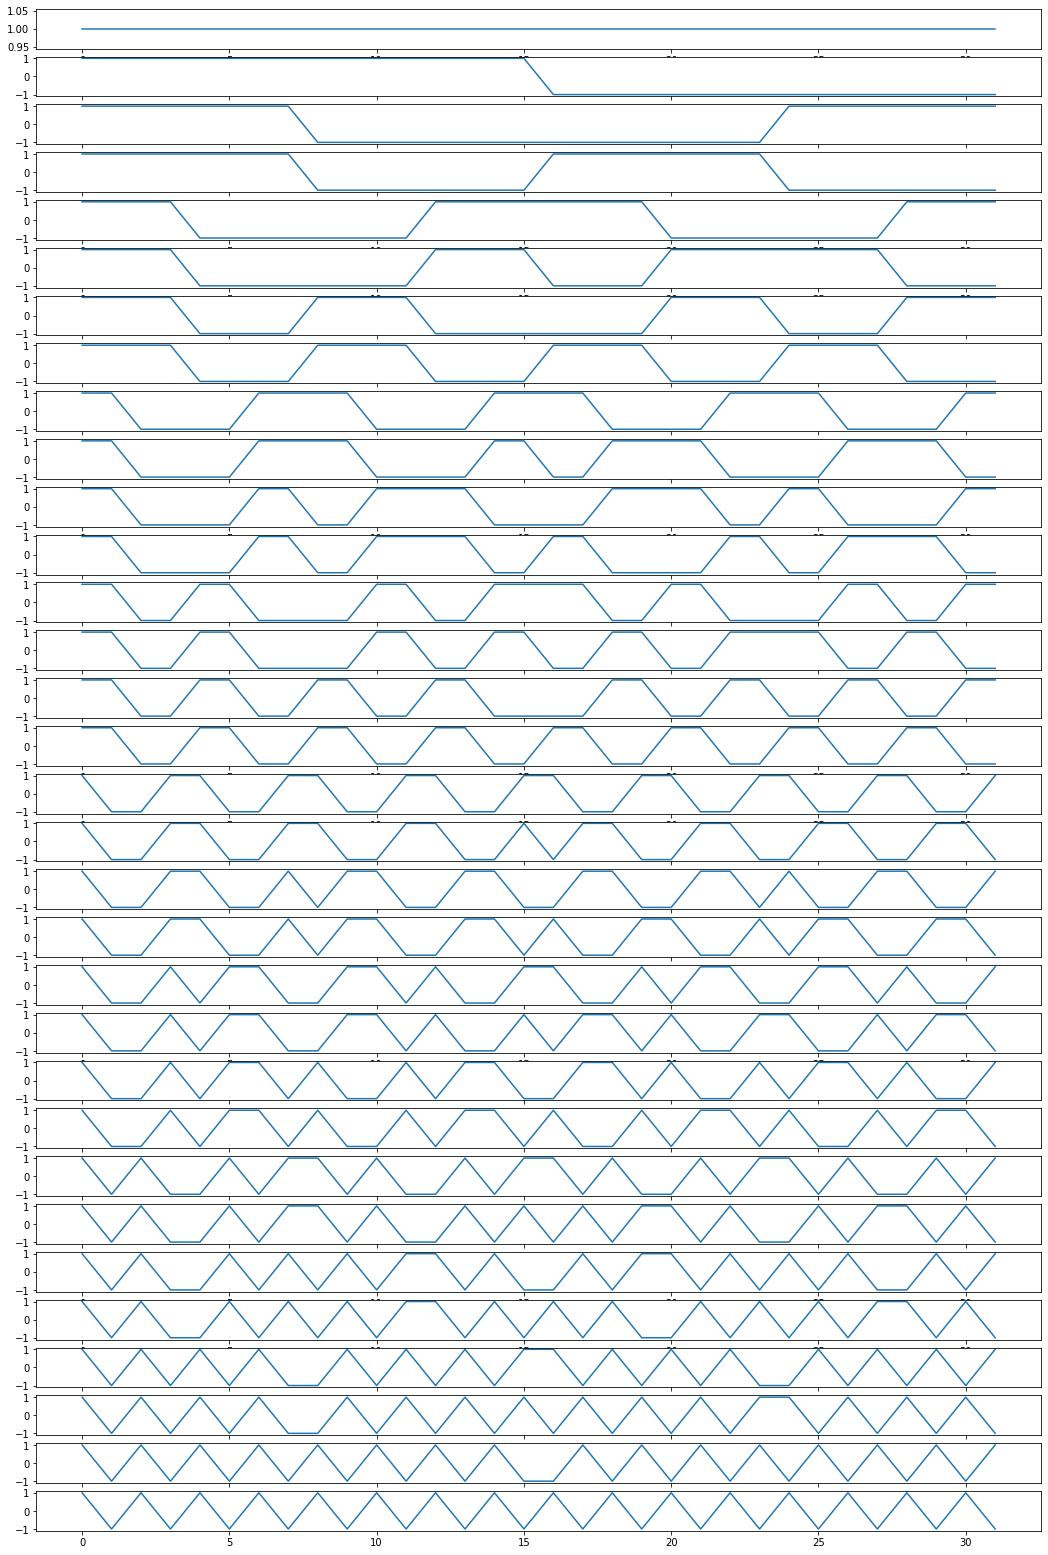

In [2]:
walsh_matrix = hadamard(32)
# reformat so 1 means multiply by -1, and 0 means multiply by 1
walsh_matrix[walsh_matrix == 1]  = 1
walsh_matrix[walsh_matrix == -1] = -1
sequency = {}

for i in range(32):
    wal_ind = ((walsh_matrix[i][:-1] * walsh_matrix[i][1:]) < 0).sum()
    sequency[wal_ind] = walsh_matrix[i]
    
    
sorted_walsh = [sequency[key] for key in sorted(sequency)]

sorted_inds = []
fig, axs = plt.subplots(32, figsize=(18,28))
for i in range(32):
    wal_ind = ((sorted_walsh[i][:-1] * sorted_walsh[i][1:]) < 0).sum()
    sorted_inds.append(wal_ind)
    axs[i].plot(sorted_walsh[i])

## What is the distribution of residuals for some fixed variance and number of samples?

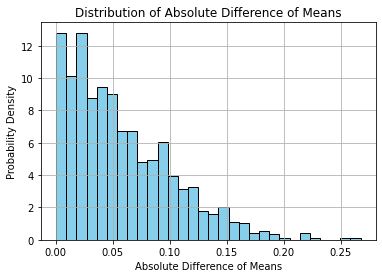

In [3]:
# Set up a number of trials, number of samples to average over, and variance 

num_trials = 1000
num_samples = 100
variance = 1  

period_base = num_samples//32
walshextended = np.zeros((2, num_samples))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

abs_diff_means = np.zeros(num_trials)


for i in range(num_trials):

    samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
    

    mean1 = np.mean(samples1)
    mean2 = np.mean(samples2)
    

    abs_diff_means[i] = np.abs(mean1 - mean2)/2


plt.hist(abs_diff_means, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Absolute Difference of Means')
plt.xlabel('Absolute Difference of Means')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

## What is the relationship between the variance and the distribution

### Try for noise 

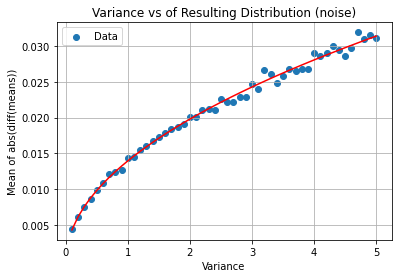

Parameters ampltiude, offset: [ 0.01412561 -0.00017203]


In [4]:
def func(x, a, b):
    return a * np.sqrt(x) + b

num_trials = 1000
num_samples = 1600
variance_values = np.linspace(0.1, 5, 50)  


mean_results = []

for variance in variance_values:
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)

popt, pcov = curve_fit(func, variance_values, mean_results)

plt.scatter(variance_values, mean_results, label='Data')
plt.plot(variance_values, func(variance_values, *popt), 'r-')
plt.title('Variance vs of Resulting Distribution (noise)')
plt.xlabel('Variance')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

### Try for noise squared

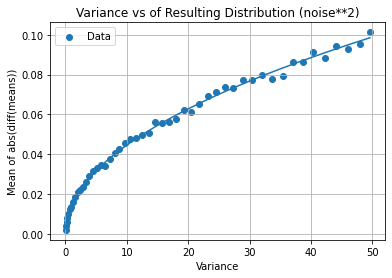

Parameters ampltiude, offset: [0.01389013 0.00064088]


In [5]:
def func(x, a, b):
    return a * np.sqrt(x) + b

# Set parameters
num_trials = 1000
num_samples = 1600
variance_values = np.linspace(0.1, 5, 50)  


mean_results = []
var_tot = []

for variance in variance_values:
    abs_diff_means = np.zeros(num_trials)
    variances = []
    for i in range(num_trials):
        
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples) ** 2
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples) ** 2
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        var1 = np.var(samples1)
        variances.append(var1)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    var_tot.append(np.mean(variances))
    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)


popt, pcov = curve_fit(func, var_tot, mean_results)


plt.scatter(var_tot, mean_results, label='Data')
plt.plot(var_tot, func(var_tot, *popt))

plt.title('Variance vs of Resulting Distribution (noise**2)')
plt.xlabel('Variance')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

### What about the number of samples 

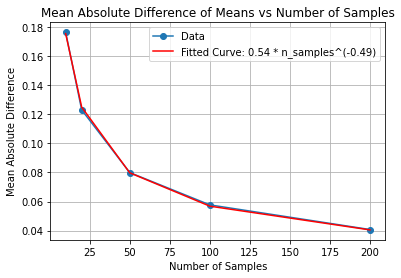

Parameters of the fitted curve (a, b): [ 0.54376711 -0.49059232]


In [6]:
def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    return np.mean(abs_diff_means)


def func(x, a, b):
    return a * np.power(x, b)


num_trials = 1000
variance = 1  
num_samples_list = [10, 20, 50, 100, 200] 


mean_abs_diff_list = []
for num_samples in num_samples_list:
    mean_abs_diff_list.append(mean_abs_diff(num_samples, num_trials, variance))


popt, pcov = curve_fit(func, num_samples_list, mean_abs_diff_list)

plt.plot(num_samples_list, mean_abs_diff_list, marker='o', label='Data')
plt.plot(num_samples_list, func(num_samples_list, *popt), 'r-', label='Fitted Curve: {:.2f} * n_samples^({:.2f})'.format(*popt))
plt.title('Mean Absolute Difference of Means vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Absolute Difference')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters of the fitted curve (a, b):", popt)

Joint fit, just to check 

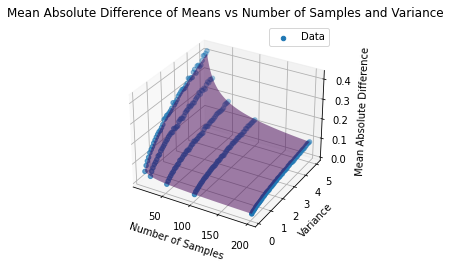

Parameters constant, spectral index: [ 0.56452994 -0.49958614]


In [7]:
from mpl_toolkits.mplot3d import Axes3D

def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)

        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        abs_diff_means[i] = np.abs(mean1 - mean2)/2
    
    return np.mean(abs_diff_means)

def func(x, a, b):
    return a * np.power(x[:, 0], b)*np.sqrt(x[:, 1])

num_trials = 1000
num_samples_list = np.array([10, 20, 50, 100, 200])  
variance_values = np.linspace(0.1, 5, 50)  

num_samples_grid, variance_grid = np.meshgrid(num_samples_list, variance_values)

mean_abs_diff_grid = np.zeros_like(num_samples_grid, dtype=float)
for i in range(num_samples_grid.shape[0]):
    for j in range(num_samples_grid.shape[1]):
        mean_abs_diff_grid[i, j] = mean_abs_diff(num_samples_grid[i, j], num_trials, variance_grid[i, j])

num_samples_flat = num_samples_grid.flatten()
variance_flat = variance_grid.flatten()
mean_abs_diff_flat = mean_abs_diff_grid.flatten()

independent_vars = np.column_stack((num_samples_flat, variance_flat))

popt, pcov = curve_fit(func, independent_vars, mean_abs_diff_flat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_samples_flat, variance_flat, mean_abs_diff_flat, marker='o', label='Data')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Variance')
ax.set_zlabel('Mean Absolute Difference')
plt.title('Mean Absolute Difference of Means vs Number of Samples and Variance')

X, Y = np.meshgrid(np.linspace(min(num_samples_list), max(num_samples_list), 100), np.linspace(min(variance_values), max(variance_values), 100))
Z = func(np.column_stack((X.flatten(), Y.flatten())), *popt).reshape(X.shape)
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, cmap='viridis')

plt.legend()
plt.show()

# Display the parameters of the fitted curve
print("Parameters constant, spectral index:", popt)

In [8]:
a,b = popt

## Check the fit 

Nsamples = 1000, Var = 15 

In [9]:
num_trials = 100000
num_samples = 1000
variance = 15  

abs_diff_means = np.zeros(num_trials)
expected_means = np.zeros(num_trials)

for i in range(num_trials):
    samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
    
    mean1 = np.mean(samples1)
    mean2 = np.mean(samples2)
    
    abs_diff_means[i] = np.abs(mean1 - mean2)/2
    
    
expected_mean = a*np.power(num_samples,b)*np.sqrt(variance)

print(expected_mean)
print(np.mean(abs_diff_means))

0.06933845948342184
0.06927318838663499


Nsamples = 3200, Var = 15 

In [10]:
# Set parameters
num_trials = 100000
num_samples = 3200
variance = 15  # Variance of the white noise

period_base = num_samples//32
walshextended = np.zeros((2, num_samples))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

abs_diff_means = np.zeros(num_trials)
expected_means = np.zeros(num_trials)

for i in range(num_trials):
    samples1 = np.random.normal(1, np.sqrt(variance), num_samples)
    walshed = samples1*walshextended[1]
    mean1 = np.mean(walshed[0:num_samples//2])
    mean2 = np.mean(walshed[num_samples//2:])

    abs_diff_means[i] = np.abs(mean1 + mean2)/2
    
expected_mean = a*np.power(num_samples/2,b)*np.sqrt(variance)

print(expected_mean)
print(np.mean(abs_diff_means))

0.05482752913632936
0.054483544702427895


## Vary the input amplitude 

In [11]:
num_trials = 100
num_samples = 3200
variance = 1 

amp = np.linspace(0,1,100)
end_means = np.zeros(len(amp))
start_means = np.zeros(len(amp))

period_base = num_samples//32
walshextended = np.zeros((2,num_samples))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base
        
j=0
for amplitude in amp:
    varsquares = []
    meanmeans = []
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = (amplitude*np.random.normal(1, np.sqrt(variance), num_samples))**2
        meanmeans.append(np.mean(samples1))
        varsquares.append(np.var(samples1))
        walshed = samples1*walshextended[1]
        mean1 = np.mean(walshed[0:num_samples//2])
        mean2 = np.mean(walshed[num_samples//2:])
        abs_diff_means[i] = np.abs(mean1 + mean2)/2
    

    squaredvar = np.mean(varsquares)   
    expected_mean = a*np.power(num_samples//2,b)*np.sqrt(squaredvar)
    start_means[j] = np.mean(meanmeans)
    end_means[j] = np.mean(abs_diff_means)
    j+=1

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


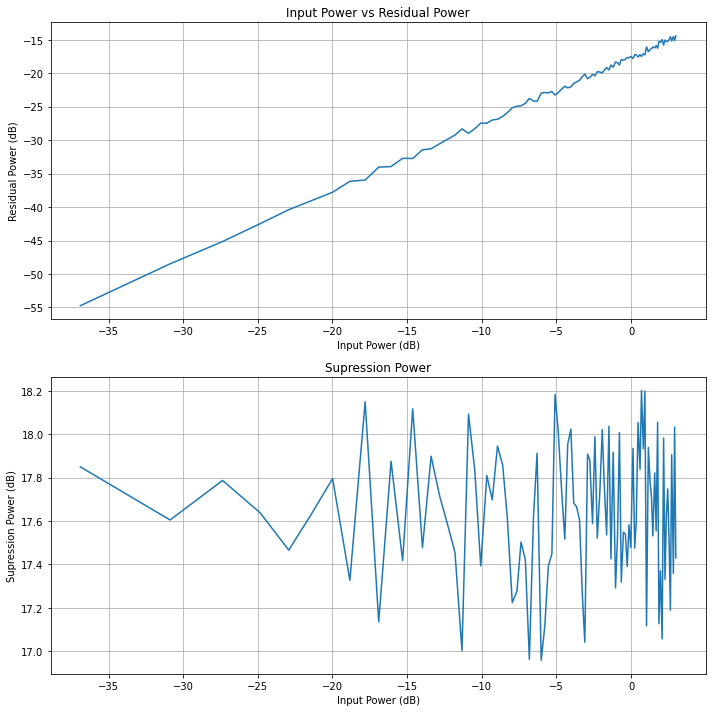

In [12]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(db(start_means), db(end_means))
ax[1].plot(db(start_means), db(start_means)-db(end_means))
ax[0].set_title('Input Power vs Residual Power')
ax[0].set_xlabel('Input Power (dB)')
ax[0].set_ylabel('Residual Power (dB)')
ax[1].set_title('Supression Power')
ax[1].set_xlabel('Input Power (dB)')
ax[1].set_ylabel('Supression Power (dB)')
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()


### Vary the input amplitude for a longer sample time 

In [13]:
sample_rate = 500e6  # 500 MHz
num_samples = 1024 * 32 * 100  # Number of samples (divisible by 1024 for FFT)
# Generate time array
t = np.arange(num_samples) / sample_rate

period_base = len(t)//32
walshextended = np.zeros((2,len(t)))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

In [14]:
# Set parameters
num_trials = 100
variance = 1 

amp = np.linspace(0,1,100)
end_means = np.zeros(len(amp))
start_means = np.zeros(len(amp))
# Repeat the process for num_trials times
j=0
for amplitude in amp:
    varsquares = []
    meanmeans = []
# Initialize array to store absolute differences of means
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        # Draw samples from white noise distribution
        samples1 = (amplitude*np.random.normal(0, np.sqrt(variance), len(t)))**2
        meanmeans.append(np.mean(samples1))
        varsquares.append(np.var(samples1))
        walshed = samples1*walshextended[1]
        mean1 = np.mean(walshed[0:num_samples//2])
        mean2 = np.mean(walshed[num_samples//2:])
        abs_diff_means[i] = np.abs(mean1 + mean2)/2
    
    #calculate the expected value
    squaredvar = np.mean(varsquares)   
    expected_mean = a*np.power(num_samples//2,b)*np.sqrt(squaredvar)
    start_means[j] = np.mean(meanmeans)
    end_means[j] = np.mean(abs_diff_means)
    j+=1

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


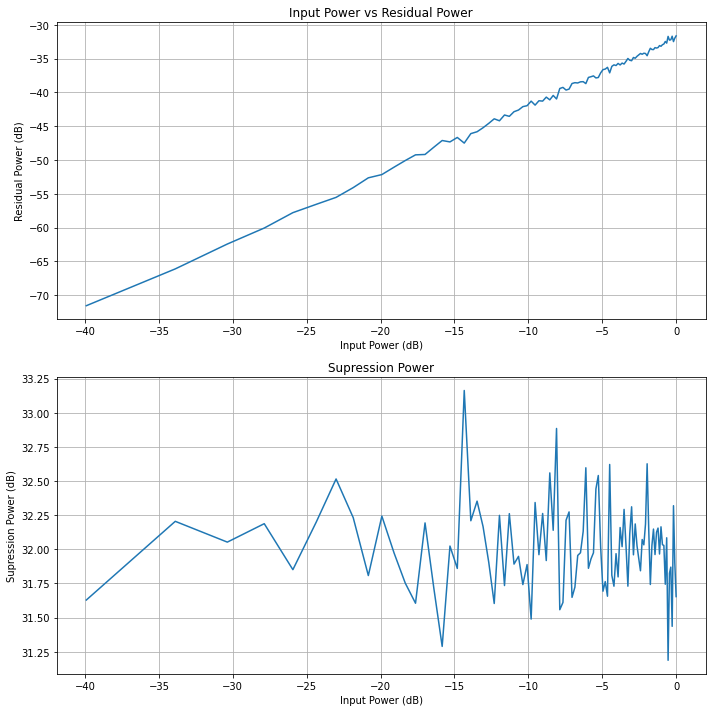

In [15]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(db(start_means), db(end_means))
ax[1].plot(db(start_means), db(start_means)-db(end_means))
ax[0].set_title('Input Power vs Residual Power')
ax[0].set_xlabel('Input Power (dB)')
ax[0].set_ylabel('Residual Power (dB)')
ax[1].set_title('Supression Power')
ax[1].set_xlabel('Input Power (dB)')
ax[1].set_ylabel('Supression Power (dB)')
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# Go for more than one square wave cycle 

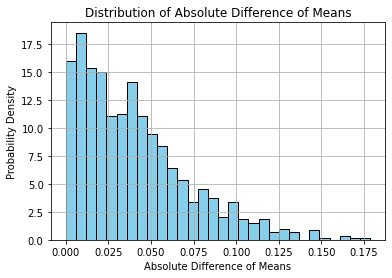

In [16]:
# Set up a number of trials, number of samples to average over, and variance 

num_trials = 1000
num_samples = 100
variance = 1  

period_base = num_samples//32
walshextended = np.zeros((2, num_samples))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

abs_diff_means = np.zeros(num_trials)


for i in range(num_trials):

    samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples3 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples4 = np.random.normal(0, np.sqrt(variance), num_samples)
    

    mean1 = np.mean(samples1)
    mean2 = np.mean(samples2)
    mean3 = np.mean(samples3)
    mean4 = np.mean(samples4)
    

    abs_diff_means[i] = np.abs(((mean1 + mean3)- (mean2-mean4))/4)


plt.hist(abs_diff_means, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Absolute Difference of Means')
plt.xlabel('Absolute Difference of Means')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

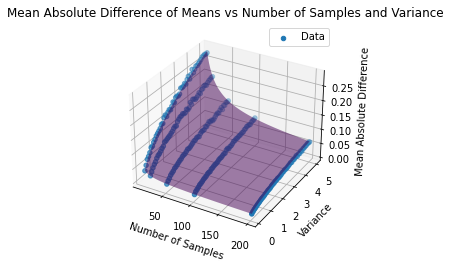

Parameters constant, spectral index: [ 0.39868536 -0.50005491]


In [17]:
from mpl_toolkits.mplot3d import Axes3D

def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples3 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples4 = np.random.normal(0, np.sqrt(variance), num_samples)
    

        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        mean3 = np.mean(samples3)
        mean4 = np.mean(samples4)
    

        abs_diff_means[i] = np.abs(((mean1 + mean3)- (mean2+mean4))/4)
    
    return np.mean(abs_diff_means)

def func(x, a, b):
    return a * np.power(x[:, 0], b)*np.sqrt(x[:, 1])

num_trials = 1000
num_samples_list = np.array([10, 20, 50, 100, 200])  
variance_values = np.linspace(0.1, 5, 50)  

num_samples_grid, variance_grid = np.meshgrid(num_samples_list, variance_values)

mean_abs_diff_grid = np.zeros_like(num_samples_grid, dtype=float)
for i in range(num_samples_grid.shape[0]):
    for j in range(num_samples_grid.shape[1]):
        mean_abs_diff_grid[i, j] = mean_abs_diff(num_samples_grid[i, j], num_trials, variance_grid[i, j])

num_samples_flat = num_samples_grid.flatten()
variance_flat = variance_grid.flatten()
mean_abs_diff_flat = mean_abs_diff_grid.flatten()

independent_vars = np.column_stack((num_samples_flat, variance_flat))

popt, pcov = curve_fit(func, independent_vars, mean_abs_diff_flat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_samples_flat, variance_flat, mean_abs_diff_flat, marker='o', label='Data')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Variance')
ax.set_zlabel('Mean Absolute Difference')
plt.title('Mean Absolute Difference of Means vs Number of Samples and Variance')

X, Y = np.meshgrid(np.linspace(min(num_samples_list), max(num_samples_list), 100), np.linspace(min(variance_values), max(variance_values), 100))
Z = func(np.column_stack((X.flatten(), Y.flatten())), *popt).reshape(X.shape)
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, cmap='viridis')

plt.legend()
plt.show()

# Display the parameters of the fitted curve
print("Parameters constant, spectral index:", popt)

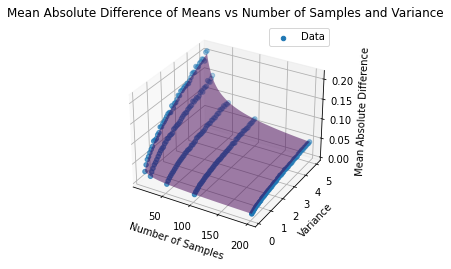

Parameters constant, spectral index: [ 0.28095296 -0.49805148]


In [18]:
from mpl_toolkits.mplot3d import Axes3D

def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples3 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples4 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples5 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples6 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples7 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples8 = np.random.normal(0, np.sqrt(variance), num_samples)
    
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        mean3 = np.mean(samples3)
        mean4 = np.mean(samples4)
        mean5 = np.mean(samples5)
        mean6 = np.mean(samples6)
        mean7 = np.mean(samples7)
        mean8 = np.mean(samples8)
    

        abs_diff_means[i] = np.abs(((mean1 + mean3 + mean5 + mean7)- (mean2 + mean4 + mean6 + mean8))/8)
    
    return np.mean(abs_diff_means)

def func(x, a, b):
    return a * np.power(x[:, 0], b)*np.sqrt(x[:, 1])

num_trials = 1000
num_samples_list = np.array([10, 20, 50, 100, 200])  
variance_values = np.linspace(0.1, 5, 50)  

num_samples_grid, variance_grid = np.meshgrid(num_samples_list, variance_values)

mean_abs_diff_grid = np.zeros_like(num_samples_grid, dtype=float)
for i in range(num_samples_grid.shape[0]):
    for j in range(num_samples_grid.shape[1]):
        mean_abs_diff_grid[i, j] = mean_abs_diff(num_samples_grid[i, j], num_trials, variance_grid[i, j])

num_samples_flat = num_samples_grid.flatten()
variance_flat = variance_grid.flatten()
mean_abs_diff_flat = mean_abs_diff_grid.flatten()

independent_vars = np.column_stack((num_samples_flat, variance_flat))

popt, pcov = curve_fit(func, independent_vars, mean_abs_diff_flat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_samples_flat, variance_flat, mean_abs_diff_flat, marker='o', label='Data')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Variance')
ax.set_zlabel('Mean Absolute Difference')
plt.title('Mean Absolute Difference of Means vs Number of Samples and Variance')

X, Y = np.meshgrid(np.linspace(min(num_samples_list), max(num_samples_list), 100), np.linspace(min(variance_values), max(variance_values), 100))
Z = func(np.column_stack((X.flatten(), Y.flatten())), *popt).reshape(X.shape)
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, cmap='viridis')

plt.legend()
plt.show()

# Display the parameters of the fitted curve
print("Parameters constant, spectral index:", popt)

### What if the noise is not the same in both channels 

In [19]:
sample_rate = 500e6  # 500 MHz
num_samples = 1024 * 32 * 100  # Number of samples (divisible by 1024 for FFT)
# Generate time array
t = np.arange(num_samples) / sample_rate

period_base = len(t)//32
walshextended = np.zeros((2,len(t)))

for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

# Set parameters
num_trials = 100
variance = 1 

amp = np.linspace(0,1,100)
end_means = np.zeros(len(amp))
start_means = np.zeros(len(amp))
# Repeat the process for num_trials times
j=0
for amplitude in amp:
    varsquares = []
    meanmeans = []
# Initialize array to store absolute differences of means
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        # Draw samples from white noise distribution
        samples1 = (amplitude*np.random.normal(0, np.sqrt(variance), len(t)))**2
        meanmeans.append(np.mean(samples1))
        varsquares.append(np.var(samples1))
        walshed = samples1*walshextended[1]
        mean1 = np.mean(walshed[0:num_samples//2])
        mean2 = np.mean(.9*walshed[num_samples//2:])
        abs_diff_means[i] = np.abs(mean1 + mean2)/2
    
    #calculate the expected value
    squaredvar = np.mean(varsquares)   
    expected_mean = a*np.power(num_samples//2,b)*np.sqrt(squaredvar)
    start_means[j] = np.mean(meanmeans)
    end_means[j] = np.mean(abs_diff_means)
    j+=1

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


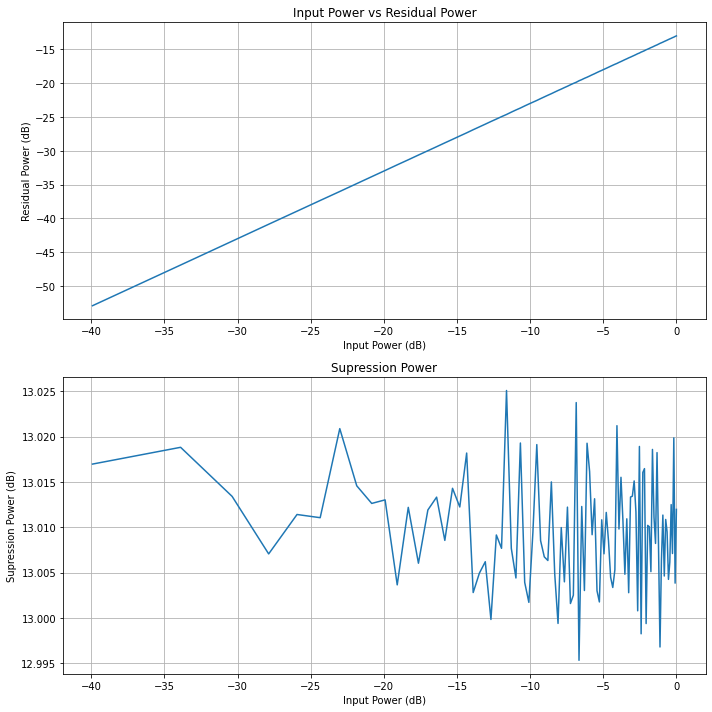

In [20]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(db(start_means), db(end_means))
ax[1].plot(db(start_means), db(start_means)-db(end_means))
ax[0].set_title('Input Power vs Residual Power')
ax[0].set_xlabel('Input Power (dB)')
ax[0].set_ylabel('Residual Power (dB)')
ax[1].set_title('Supression Power')
ax[1].set_xlabel('Input Power (dB)')
ax[1].set_ylabel('Supression Power (dB)')
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()

## What about sinusoidally varying signals

 try perfect integer integration time

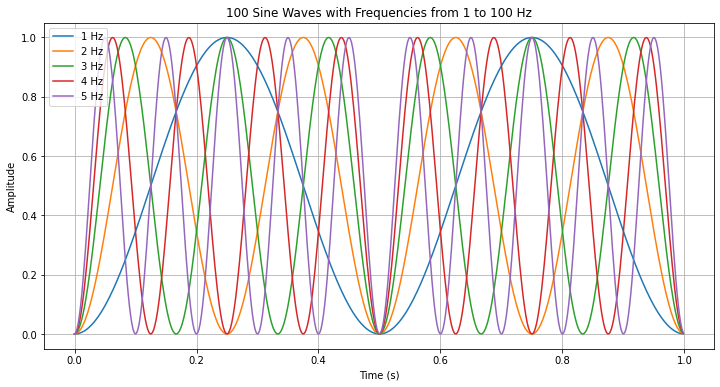

In [21]:
duration = 1
sampling_rate = 500  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies = np.arange(1, 101)
sine_waves = np.zeros((100, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2

plt.figure(figsize=(12, 6))
for i in range(5):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('100 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

100
100


/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


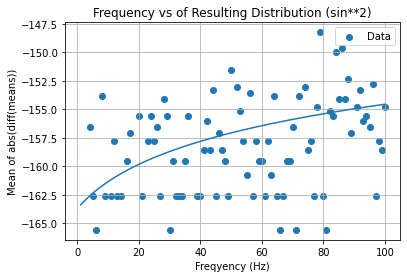

Parameters ampltiude, offset: [3.07584755e-18 4.28445069e-17]


In [22]:
def func(x, a, b):
    return a * x + b

num_trials = 100 

mean_results = []


for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)

print(len(frequencies))
print(len(mean_results))
    
popt, pcov = curve_fit(func, frequencies, mean_results)


plt.scatter(frequencies, db(mean_results), label='Data')
plt.plot(frequencies, db(func(frequencies, *popt)))

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

non-perfect integer integration

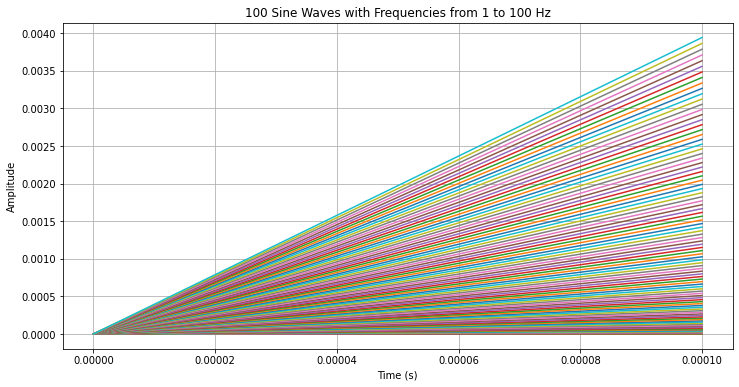

In [23]:
duration = .00025
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies = np.arange(1, 101)
sine_waves = np.zeros((100, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2

plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('100 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

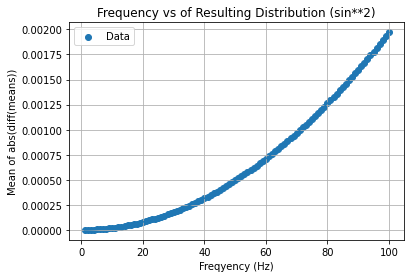

Parameters ampltiude, offset: [1.98387500e-07 1.99864413e+00]


In [24]:
def func(x, a, b):
    return a * np.power(x,b) 

num_trials = 100 

mean_results = []


for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results)


plt.scatter(frequencies, mean_results, label='Data')
plt.plot(frequencies, func(frequencies, *popt))

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

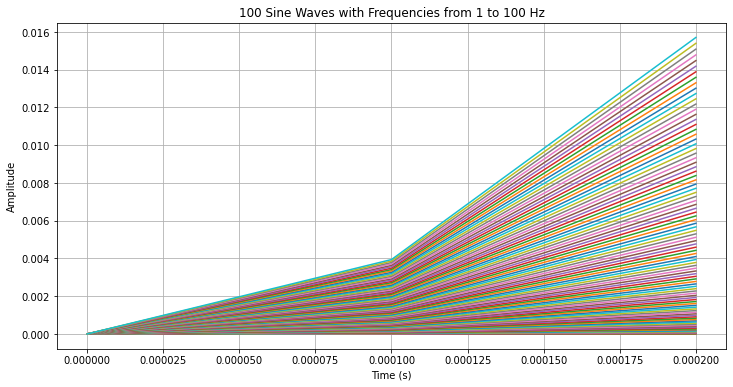

In [25]:
duration = .00025*(3/2)
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies = np.arange(1, 101)
sine_waves = np.zeros((100, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2

plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('100 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

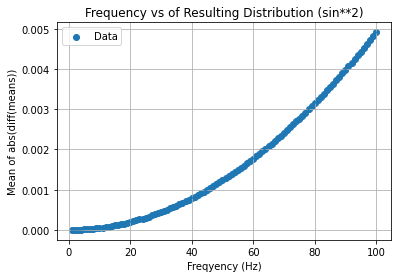

Parameters ampltiude, offset: [5.01986712e-07 1.99539264e+00]


In [26]:
def func(x, a, b):
    return a * np.power(x,b) 

num_trials = 100 

mean_results = []


for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results)


plt.scatter(frequencies, mean_results, label='Data')
plt.plot(frequencies, func(frequencies, *popt))

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

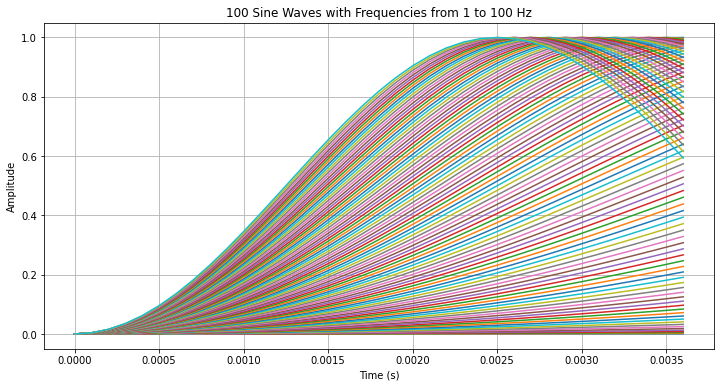

In [27]:
duration = .00025*(15)
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies = np.arange(1, 101)
sine_waves = np.zeros((100, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2

plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('100 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

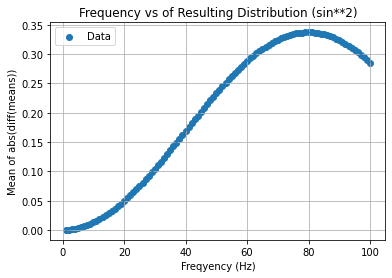

Parameters ampltiude, offset: [0.33685392 0.01968516]


In [28]:
guess = [.325, 0.01]

def func(x, a, b):
    return a * np.sin(b*x)**2 

num_trials = 100 

mean_results = []


for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results,  p0=guess)


plt.scatter(frequencies, mean_results, label='Data')
plt.plot(frequencies, func(frequencies, *popt))

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

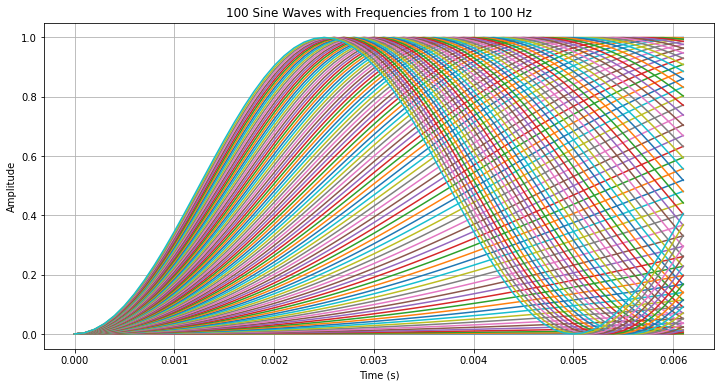

In [253]:
duration = .00025*(25)
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies = np.arange(1, 101)
sine_waves = np.zeros((100, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2

plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('100 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

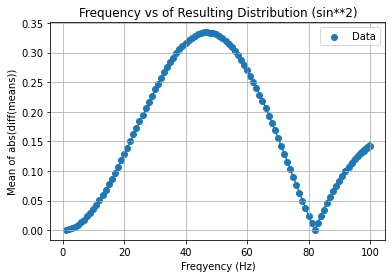

Parameters ampltiude, offset: [0.01916631 1.00458723]


In [255]:
guess = [np.pi*.00625, .325]

def func(x, a, b):
    return  abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x))

num_trials = 100 

mean_results = []


for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = np.abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results,maxfev = 100000,p0=guess)


plt.scatter(frequencies, mean_results, label='Data')
plt.plot(frequencies, func(frequencies, *popt))

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

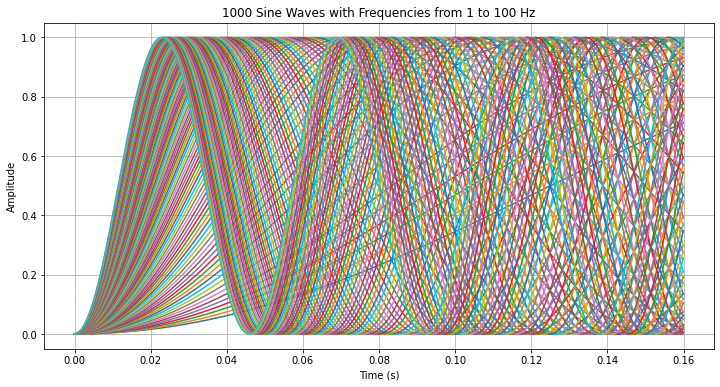

In [92]:
duration = .005*32
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies =  np.linspace(1, 101,1000)
sine_waves = np.zeros((1000, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2
    
plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('1000 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

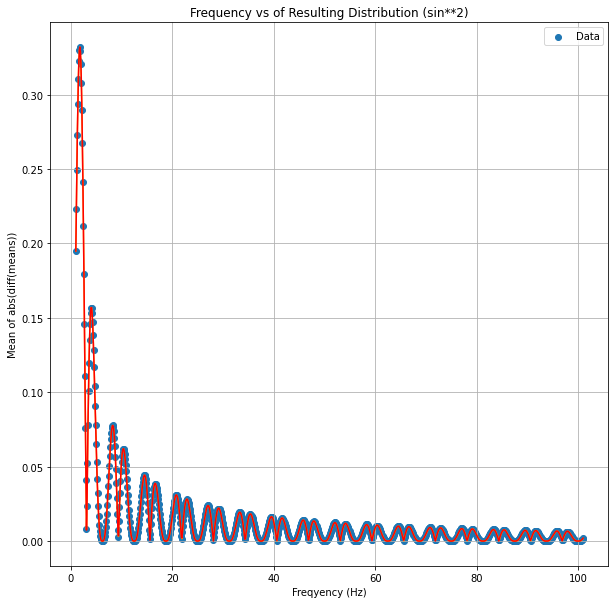

Parameters ampltiude, offset: [0.50241921 0.99991094]


In [98]:
guess = [np.pi*duration, .325]
def func(x, a, b):
    return  abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x))

# abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x)**2) #this one kinds works

num_trials = 100 

mean_results = []

def expression(f, t, N):
    result = np.abs((-2 * np.sin(2 * np.pi * f * t) + np.sin(2 * 2 * np.pi * f * t)) / (8*np.pi* f * t ))
    return result

for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine[0:len(sine)//2]
        samples2 = sine[len(sine)//2:]
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)

        abs_diff_means[i] = abs(mean1 - mean2)/2

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results, p0=guess, maxfev=1000000)

plt.figure(figsize=(10,10))
plt.scatter(frequencies, mean_results, label='Data')
plt.plot(frequencies, func(frequencies, *popt), c='orange')
plt.plot(frequencies, expression(frequencies,duration,1), c = 'red')
#plt.plot(frequencies, abs((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2)
#plt.plot(frequencies, 1/(((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2))

x = 2*np.pi*frequencies*duration



#expr = np.sin(x)**3 *np.cos(x) / x**3

# Take the absolute value
#abs_expr = expr

#plt.scatter(frequencies, expr, label='Data')

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

# What about a more complex walsh function

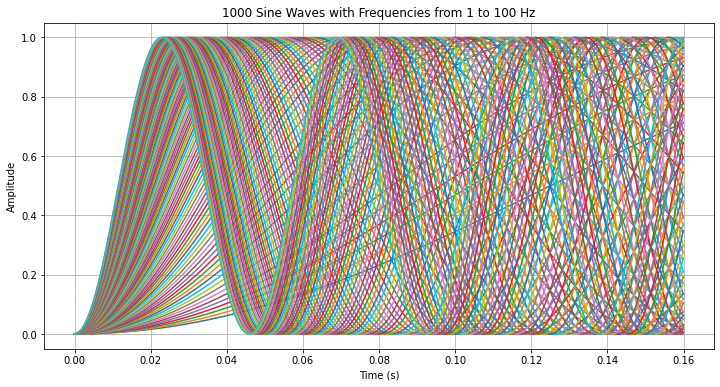

In [34]:
# Set parameters
duration = .005*32
sampling_rate = 10000  # Hz
num_samples = int(duration * sampling_rate)
time = np.arange(num_samples) / sampling_rate

frequencies =  np.linspace(1, 101, 1000)
sine_waves = np.zeros((1000, num_samples))

for i, freq in enumerate(frequencies):
    sine_waves[i] = (np.sin(2 * np.pi * freq * time))**2
    
plt.figure(figsize=(12, 6))
for i in range(100):  
    plt.plot(time, sine_waves[i], label=f'{frequencies[i]} Hz')
plt.title('1000 Sine Waves with Frequencies from 1 to 100 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

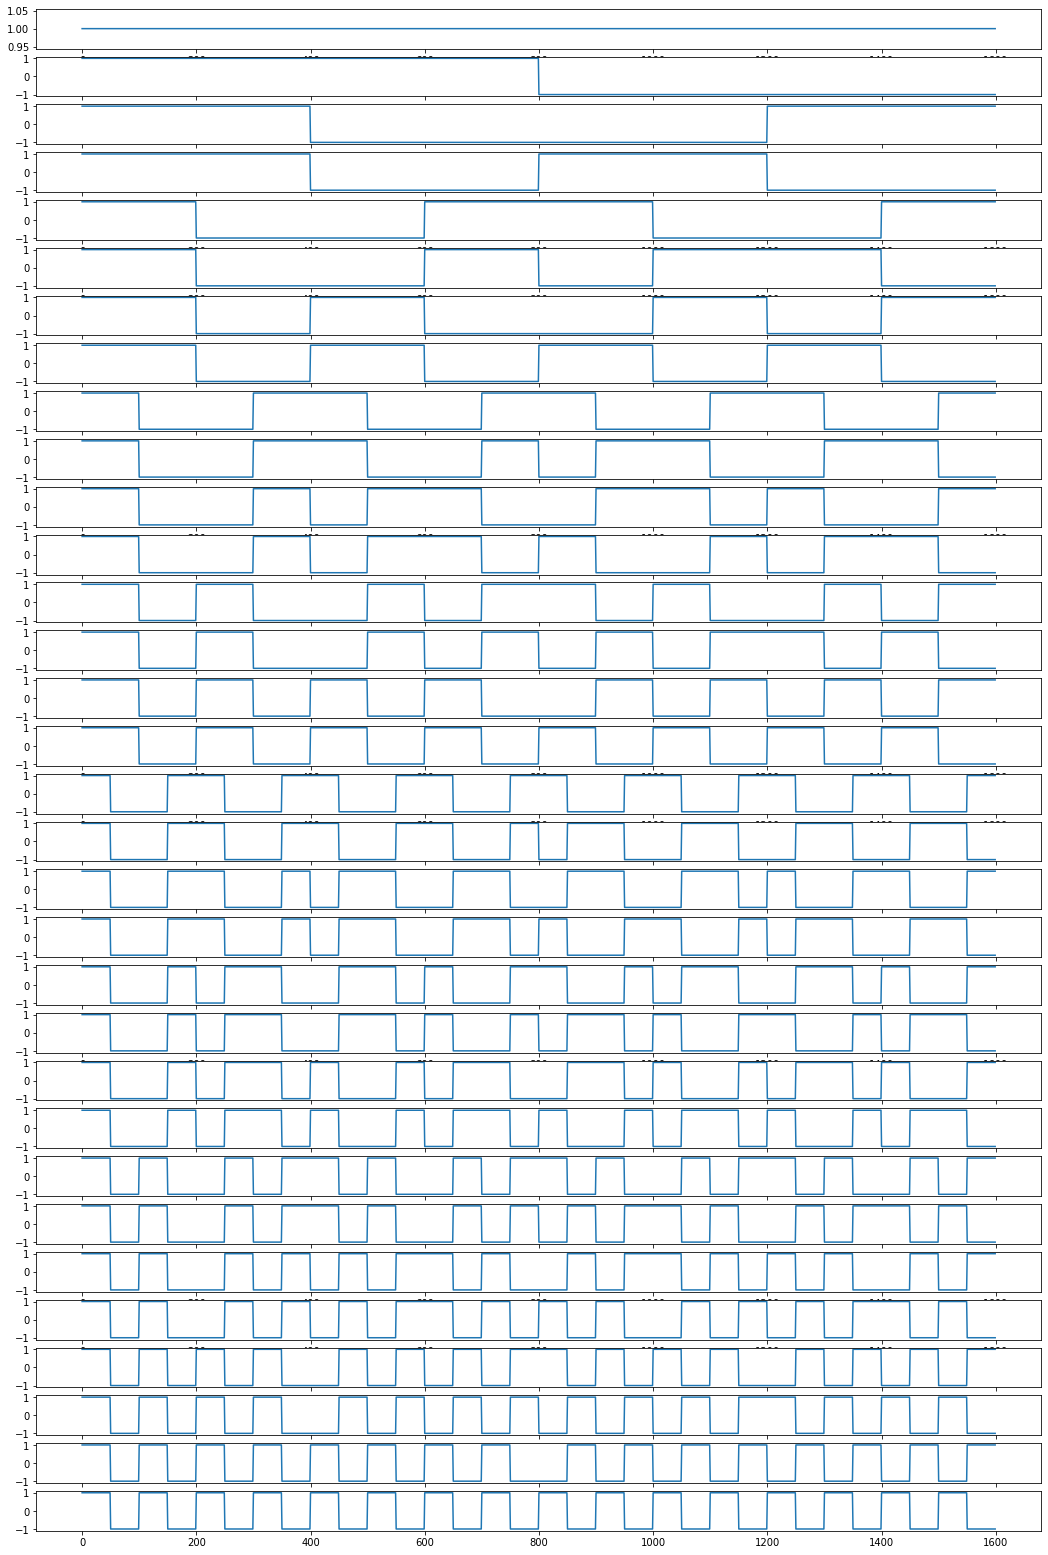

In [35]:
num_trials = 10
num_samples = num_samples
period_base = num_samples//32
walshextended = np.zeros((32, num_samples))

for i in range(32):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(sorted_walsh[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base
        
fig, axs = plt.subplots(32, figsize=(18,28))
for i in range(32):
    axs[i].plot(walshextended[i])

Result: 7.796343665038751e-17


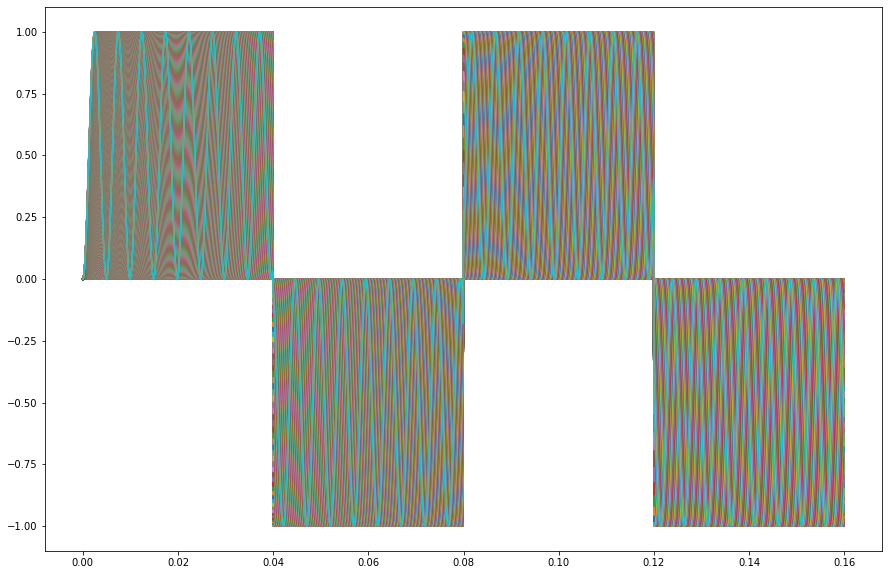

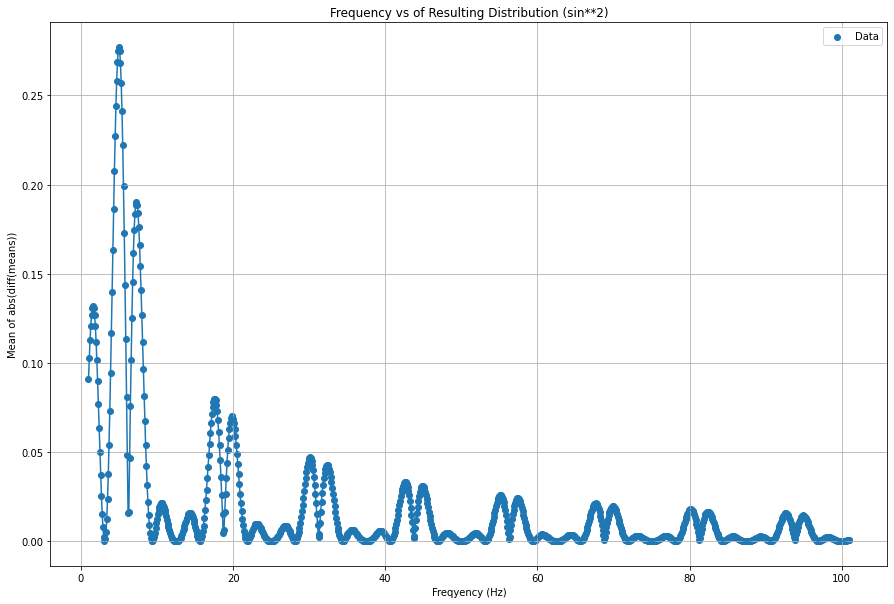

Parameters ampltiude, offset: [0.16618867 0.43697842]


In [90]:
guess = [np.pi*.0625, .325]
def func(x, a, b):
    return  abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x))

# abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x)**2) #this one kinds works
def expression(f):
    return abs((-2 * np.sin(f*np.pi) + 2 * np.sin(2*f*np.pi) - 2 * np.sin(3*f*np.pi) + np.sin(4*f*np.pi)) / (8 * np.pi * f))


# Example usage:
t_value = 1.0  # You can change this value
result = expression(t_value)
print("Result:", result)


num_trials = 1

mean_results = []

plt.figure(figsize=(15,10))
for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine*walshextended[3]
        
        plt.plot(time, samples1, label=f'{frequencies[i]} Hz')
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)

        abs_diff_means[i] = abs(mean1)
        
        

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results, p0=guess, maxfev=1000000)

plt.figure(figsize=(15,10))
plt.scatter(frequencies, mean_results, label='Data')

#plt.plot(frequencies, func(frequencies, *popt), c='orange')
#plt.plot(frequencies, abs((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2)
#plt.plot(frequencies, 1/(((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2))

x = frequencies*.005*32


plt.plot(frequencies, expression(x))
#plt.plot(frequencies, expression2(x))
#expr = np.sin(x)**3 *np.cos(x) / x**3

# Take the absolute value
#abs_expr = expr

#plt.scatter(frequencies, expr, label='Data')

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

Result: 0.0


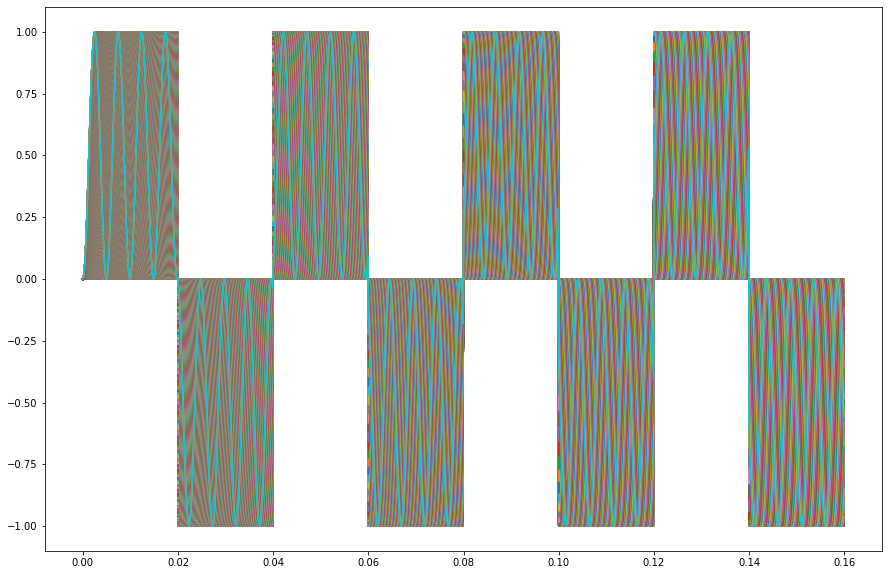

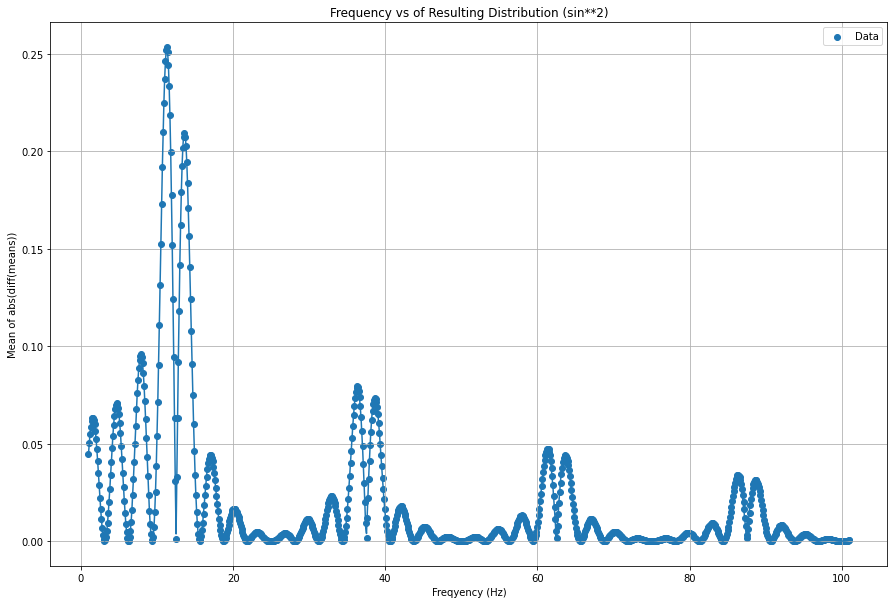

Parameters ampltiude, offset: [3.98407319 5.76897233]


In [89]:
guess = [4, .325]
def func(f, N, b):
    return  abs(2*(- np.sin(f*np.pi/N) + np.sin(2*f*np.pi/N) -  np.sin(3*f*np.pi/N) + np.sin(4*f*np.pi/N) - np.sin(5*f*np.pi/N) +  np.sin(6*f*np.pi/N) -  np.sin(7*f*np.pi/N)) + np.sin(8*f*np.pi/N)) / (b*N*f)

# abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x)**2) #this one kinds works
def expression(f, N):
    return abs(2*(- np.sin(2*f*np.pi/N) + np.sin(2*2*f*np.pi/N) -  np.sin(2*3*f*np.pi/N) + np.sin(2*4*f*np.pi/N) - np.sin(2*5*f*np.pi/N) +  np.sin(2*6*f*np.pi/N) -  np.sin(2*7*f*np.pi/N)) + np.sin(2*8*f*np.pi/N)) / (2*np.pi*N*f)



def compute_expression_difference(f):
    # Define constants
    pi = np.pi
    
    # Compute the expression
    term1 = (f * pi + 2 * np.sin(f * pi / 2) - 2 * np.sin(f * pi)) / (16 * f * pi)
    term2 = (pi * f + 2 * np.sin(3 * pi * f / 2) - 2 * np.sin(2 * pi * f)) / (16 * pi * f)
    term3 = (f * pi + 2 * np.sin(5 * f * pi / 2) - 2 * np.sin(3 * f * pi)) / (16 * f * pi)
    term4 = (f * pi + 2 * np.sin(7 * f * pi / 2) - 2 * np.sin(4 * f * pi)) / (16 * f * pi)
    
        # Compute the expression
    term5 = (1/16 - np.sin(f * pi / 2) / (8 * f * pi))
    term6 = (f * pi + 2 * np.sin(f * pi) - 2 * np.sin(3 * f * pi / 2)) / (16 * f * pi)
    term7 = (f * pi + 2 * np.sin(2 * f * pi) - 2 * np.sin(5 * f * pi / 2)) / (16 * f * pi)
    term8 = (f * pi + 2 * np.sin(3 * f * pi) - 2 * np.sin(7 * f * pi / 2)) / (16 * f * pi)
    
    return abs(term1 + term2 + term3 + term4 - (term5 + term6 + term7 + term8))

# Example usage:
f_value = 0.5
result = compute_expression_difference(f_value)
print("Result:", result)

num_trials = 1

mean_results = []

plt.figure(figsize=(15,10))
for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine*walshextended[7]
        
        plt.plot(time, samples1, label=f'{frequencies[i]} Hz')
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)

        abs_diff_means[i] = abs(mean1)
        
        

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results, p0=guess, maxfev=1000000)

plt.figure(figsize=(15,10))
plt.scatter(frequencies, mean_results, label='Data')

#plt.plot(frequencies, func(frequencies, *popt), c='orange')
#plt.plot(frequencies, abs((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2)
#plt.plot(frequencies, 1/(((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2))

x = frequencies*.005*32


plt.plot(frequencies,expression(x,4))
#plt.plot(frequencies, expression2(x))
#expr = np.sin(x)**3 *np.cos(x) / x**3

# Take the absolute value
#abs_expr = expr

#plt.scatter(frequencies, expr, label='Data')

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

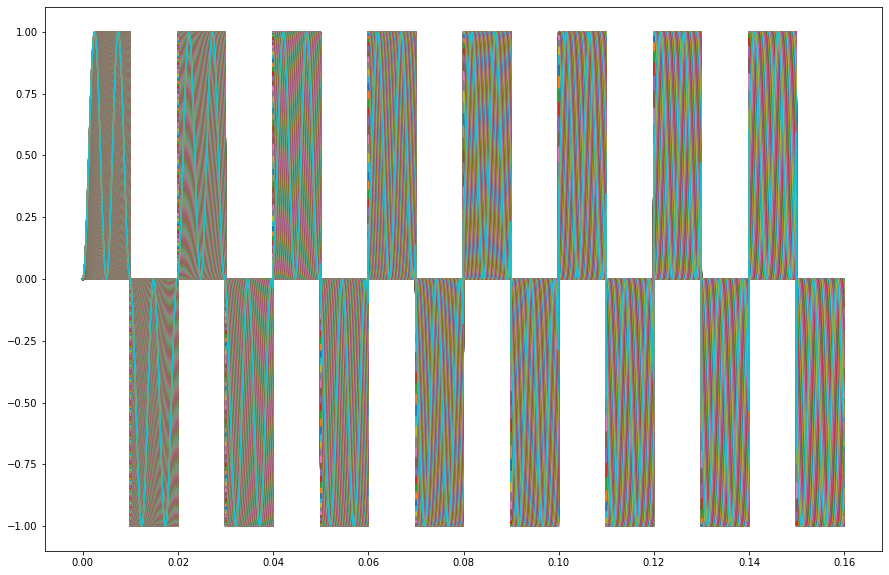

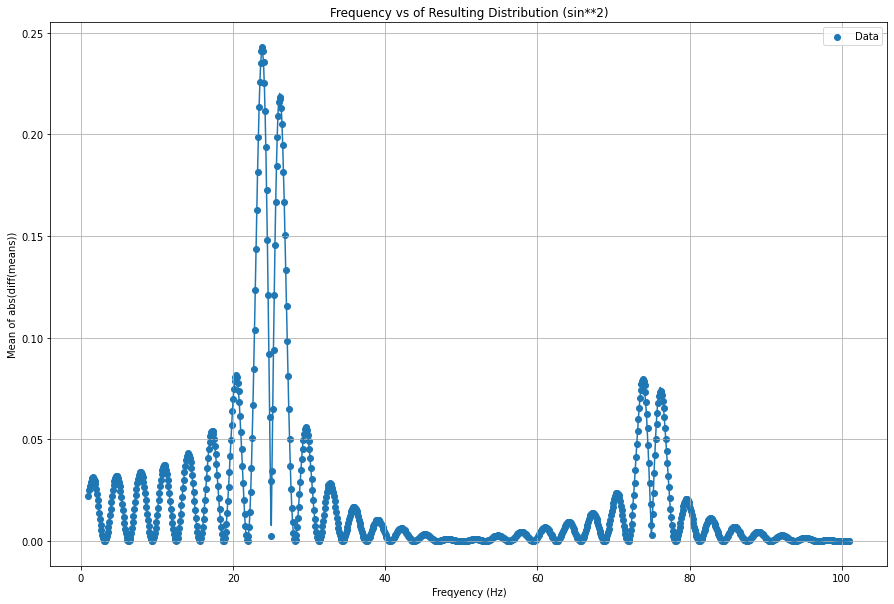

Parameters ampltiude, offset: [0.16652996 0.17739862]


In [101]:
guess = [np.pi*.0625, .325]
def func(x, a, b):
    return  abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x))

# abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x)**2) #this one kinds works
def expression(f, N):
    return abs(2*(- np.sin(2*f*np.pi/N) + np.sin(2*2*f*np.pi/N) -  np.sin(2*3*f*np.pi/N) + np.sin(2*4*f*np.pi/N) - np.sin(2*5*f*np.pi/N) +  np.sin(2*6*f*np.pi/N) -  np.sin(2*7*f*np.pi/N) + np.sin(2*8*f*np.pi/N) -  np.sin(2*9*f*np.pi/N) + np.sin(2*10*f*np.pi/N) - np.sin(2*11*f*np.pi/N) +  np.sin(2*12*f*np.pi/N) -  np.sin(2*13*f*np.pi/N)  + np.sin(2*14*f*np.pi/N) -  np.sin(2*15*f*np.pi/N)) +  np.sin(2*16*f*np.pi/N))/ (8*np.pi*f)

num_trials = 1

mean_results = []

plt.figure(figsize=(15,10))
for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine*walshextended[15]
        
        plt.plot(time, samples1, label=f'{frequencies[i]} Hz')
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)

        abs_diff_means[i] = abs(mean1)
        
        

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results, p0=guess, maxfev=1000000)

plt.figure(figsize=(15,10))
plt.scatter(frequencies, mean_results, label='Data')

#plt.plot(frequencies, func(frequencies, *popt), c='orange')
#plt.plot(frequencies, abs((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2)
#plt.plot(frequencies, 1/(((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2))

x = frequencies*.005*32


plt.plot(frequencies,expression(x,8))
#plt.plot(frequencies, expression2(x))
#expr = np.sin(x)**3 *np.cos(x) / x**3

# Take the absolute value
#abs_expr = expr

#plt.scatter(frequencies, expr, label='Data')

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

Result: 7.796343665038751e-17


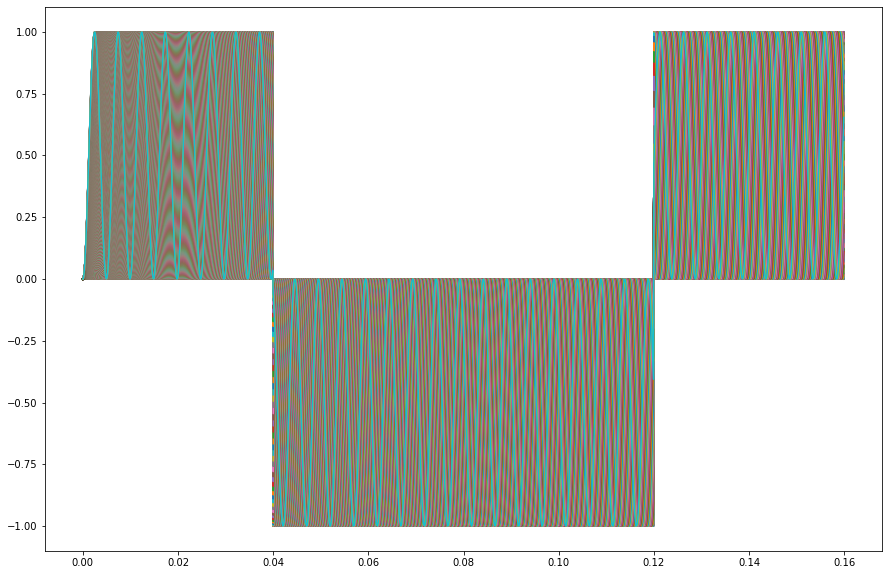

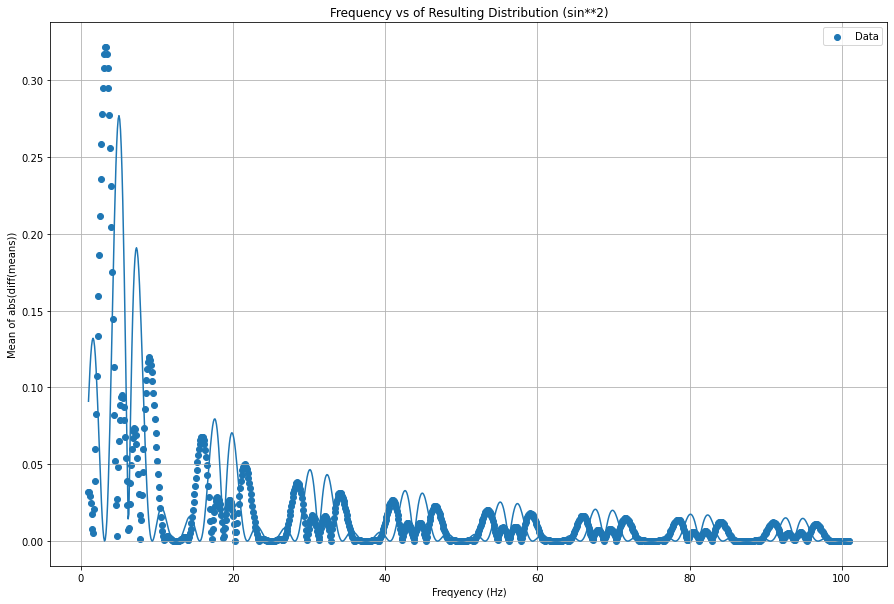

Parameters ampltiude, offset: [0.2522547  0.63862169]


In [102]:
guess = [np.pi*.0625, .325]
def func(x, a, b):
    return  abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x))

# abs(b*(np.sin(a*x)**3*np.cos(a*x)) / (a*x)**2) #this one kinds works
def expression(f):
    return abs((2 * np.sin(f*np.pi) - 2 * np.sin(2*f*np.pi) + 2 * np.sin(3*f*np.pi) - np.sin(4*f*np.pi)) / (8 * np.pi * f))


# Example usage:
t_value = 1.0  # You can change this value
result = expression(t_value)
print("Result:", result)


num_trials = 1

mean_results = []

plt.figure(figsize=(15,10))
for sine in sine_waves:
    abs_diff_means = np.zeros(num_trials)

    for i in range(num_trials):
        
        samples1 = sine*walshextended[2]
        
        plt.plot(time, samples1, label=f'{frequencies[i]} Hz')
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)

        abs_diff_means[i] = abs(mean1)
        
        

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)
    
popt, pcov = curve_fit(func, frequencies, mean_results, p0=guess, maxfev=1000000)

plt.figure(figsize=(15,10))
plt.scatter(frequencies, mean_results, label='Data')

#plt.plot(frequencies, func(frequencies, *popt), c='orange')
#plt.plot(frequencies, abs((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2)
#plt.plot(frequencies, 1/(((2.5*np.sin(np.pi*frequencies*.0625)/frequencies))**2))

x = frequencies*.005*32


plt.plot(frequencies, expression(x))
#plt.plot(frequencies, expression2(x))
#expr = np.sin(x)**3 *np.cos(x) / x**3

# Take the absolute value
#abs_expr = expr

#plt.scatter(frequencies, expr, label='Data')

plt.title('Frequency vs of Resulting Distribution (sin**2)')
plt.xlabel('Freqyency (Hz)')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters ampltiude, offset:", popt)

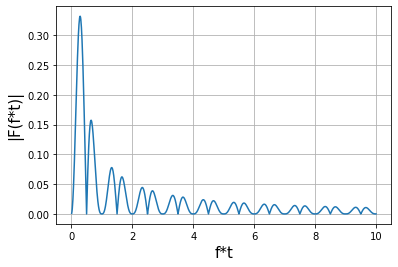

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def abs_function(f):
    numerator = np.sin(4 * f * np.pi) - 2 * np.sin(2 * f * np.pi)
    denominator = 8 * f * np.pi
    result = abs(numerator / denominator)
    return result

# Define the range of f values
f_values = np.linspace(0.01, 10, 1000)  # Range from 0.01 to 2 with 100 points

# Compute the corresponding function values
abs_values = [abs_function(f) for f in f_values]

# Plot the function

plt.plot(f_values, abs_values)
plt.xlabel('f*t',fontsize=15)
plt.ylabel('|F(f*t)|',fontsize=15)
#plt.title('Absolute Value of the Function')
plt.grid(True)
plt.savefig('func.pdf',format='pdf')
plt.show()

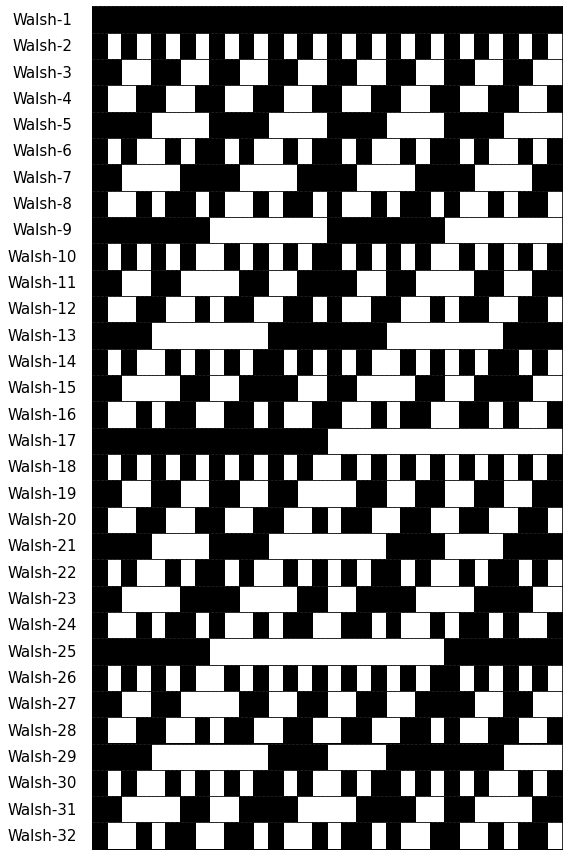

In [308]:
import numpy as np
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

# Number of Walsh functions to plot
num_functions = 32

# Generate the Walsh functions
walsh_functions = hadamard(num_functions)

# Create a shared x-axis
fig, axes = plt.subplots(num_functions, 1, sharex=True, figsize=(8, 12))

# Plot the Walsh functions
for i, ax in enumerate(axes):
    ax.fill_between(np.arange(0, num_functions+1), np.append(walsh_functions[i], walsh_functions[i][-1]), step='post', color='black')
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', linestyle='--')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)  # Remove both xticks, yticks, and their labels
    ax.set_ylabel(f'Walsh-{i+1}', rotation='horizontal', labelpad=50, horizontalalignment='center', verticalalignment='center', fontsize=15)

# Set x-axis limits and ticks
plt.xticks(np.arange(0, num_functions+1))
plt.xlim(0, num_functions)

plt.tight_layout(h_pad=0)
plt.savefig('Walsh_nat.pdf')
plt.show()

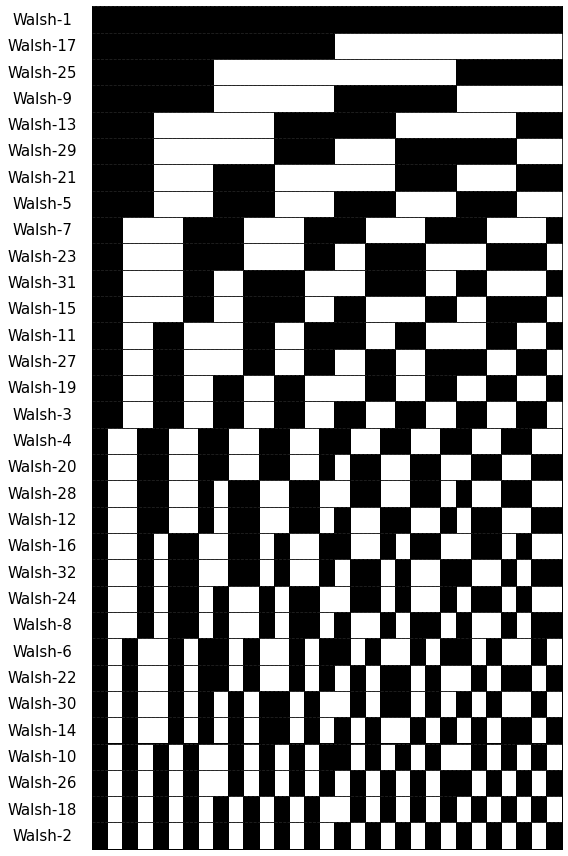

In [314]:
import numpy as np
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

# Number of Walsh functions to plot
num_functions = 32

# Generate the Walsh functions
walsh_functions = hadamard(num_functions)

# Compute the sequency of each Walsh function
sequency = np.sum(np.abs(np.diff(walsh_functions, axis=1)), axis=1)

# Sort the Walsh functions based on sequency
sorted_indices = np.argsort(sequency)

# Create a shared x-axis
fig, axes = plt.subplots(num_functions, 1, sharex=True, figsize=(8, 12))

# Plot the sorted Walsh functions
for i, ax in enumerate(axes):
    ax.fill_between(np.arange(0, num_functions), walsh_functions[sorted_indices[i]], step='post', color='black')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 32)
    ax.grid(True, axis='y', linestyle='--')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)  # Remove both xticks, yticks, and their labels
    ax.set_ylabel(f'Walsh-{sorted_indices[i]+1}', rotation='horizontal', labelpad=50, fontsize=15, horizontalalignment='center', verticalalignment='center')

# Set x-axis limits and ticks
plt.xticks(np.arange(0, num_functions+1))
plt.xlim(0, 31)
plt.ylim(0,1)

plt.tight_layout(h_pad=0)
plt.savefig('Walsh_seq.pdf',format='pdf')
plt.show()